
Processing master folder: ../2-archive-runs

Processing folder: ../2-archive-runs/2-aaa-400-small-deterministic-old-config
Combined plot saved for scenario 6ac-400-small-deterministic at ../2-archive-runs/2-aaa-400-small-deterministic-old-config/6ac-400-small-deterministic/plots/averaged_rewards_over_steps_6ac-400-small-deterministic.png


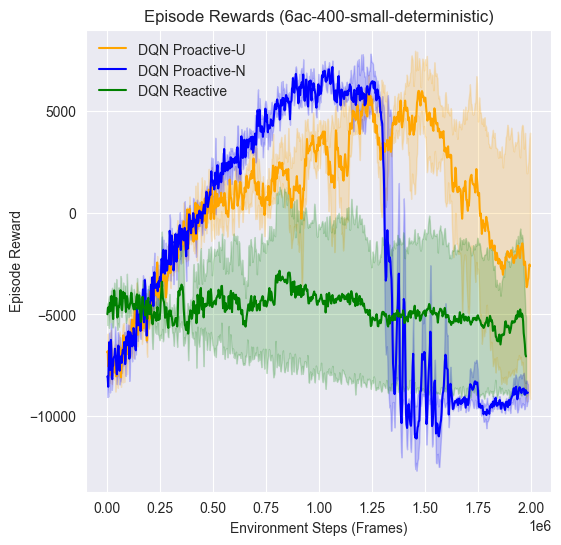

all seeds: {242424, 232323}

Processing folder: ../2-archive-runs/29-run
No .npy files found in ../2-archive-runs/29-run/6ac-1-deterministic/numpy

Processing folder: ../2-archive-runs/14-run
Skipping 6ac-100-superdiverse - no numpy folder found

Processing folder: ../2-archive-runs/16-run
Skipping 6ac-1-deterministic - no numpy folder found

Processing folder: ../2-archive-runs/17-run
Skipping 6ac-1-deterministic - no numpy folder found

Processing folder: ../2-archive-runs/13-run
Skipping 6ac-10000-superdiverse - no numpy folder found

Processing folder: ../2-archive-runs/2-aaa-400-small-deterministic
Combined plot saved for scenario 6ac-400-small-deterministic at ../2-archive-runs/2-aaa-400-small-deterministic/6ac-400-small-deterministic/plots/averaged_rewards_over_steps_6ac-400-small-deterministic.png


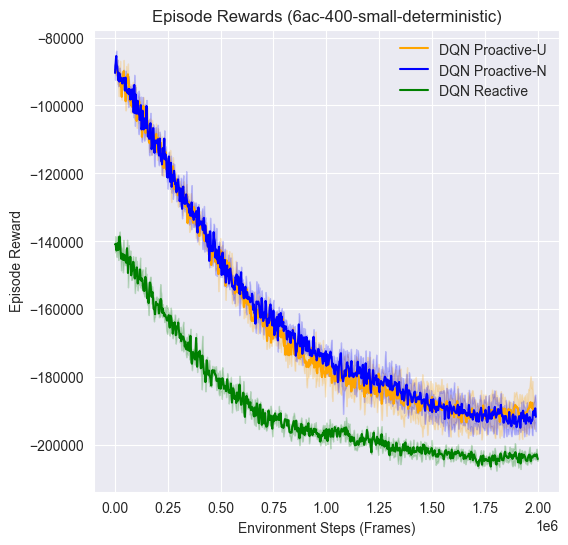

all seeds: {242424, 232323}

Processing folder: ../2-archive-runs/12-run
No .npy files found in ../2-archive-runs/12-run/6ac-10000-superdiverse/numpy
Skipping 3ac-100-superdiverse - no numpy folder found

Processing folder: ../2-archive-runs/10-run
Combined plot saved for scenario 6ac-10000-superdiverse at ../2-archive-runs/10-run/6ac-10000-superdiverse/plots/averaged_rewards_over_steps_6ac-10000-superdiverse.png


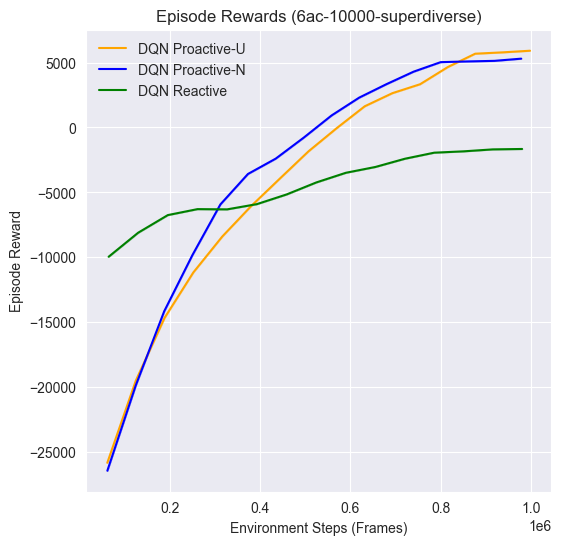

all seeds: {2323}

Processing folder: ../2-archive-runs/11-run
Combined plot saved for scenario 6ac-10000-superdiverse at ../2-archive-runs/11-run/6ac-10000-superdiverse/plots/averaged_rewards_over_steps_6ac-10000-superdiverse.png


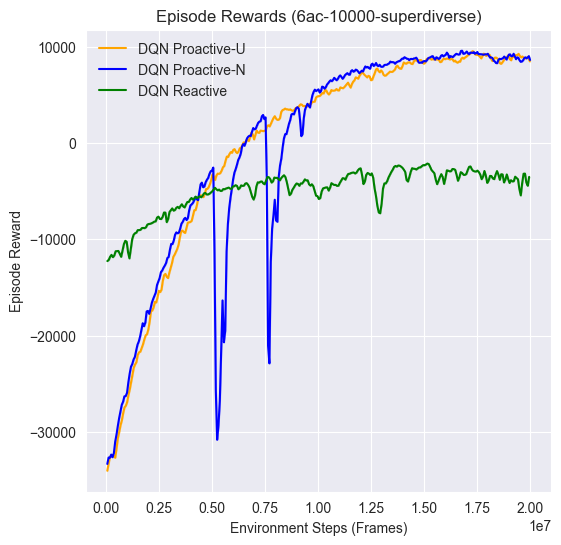

all seeds: {2020}

Processing folder: ../2-archive-runs/8-run
Combined plot saved for scenario 6ac-100-superdiverse at ../2-archive-runs/8-run/6ac-100-superdiverse/plots/averaged_rewards_over_steps_6ac-100-superdiverse.png


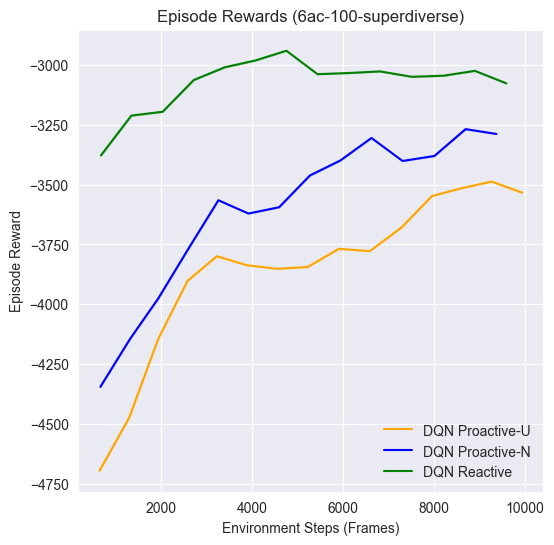

all seeds: {111}

Processing folder: ../2-archive-runs/5-run
Combined plot saved for scenario 6ac-100-superdiverse at ../2-archive-runs/5-run/6ac-100-superdiverse/plots/averaged_rewards_over_steps_6ac-100-superdiverse.png


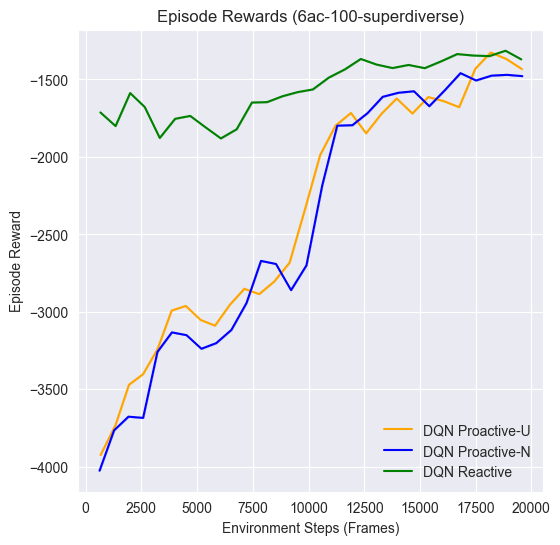

all seeds: {111}

Processing folder: ../2-archive-runs/4-run
Combined plot saved for scenario 6ac-10000-superdiverse at ../2-archive-runs/4-run/6ac-10000-superdiverse/plots/averaged_rewards_over_steps_6ac-10000-superdiverse.png


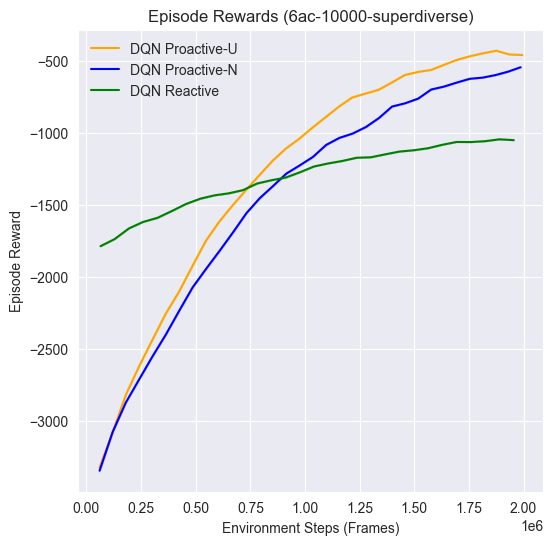

all seeds: {111}

Processing folder: ../2-archive-runs/6-run
Combined plot saved for scenario 6ac-100-superdiverse at ../2-archive-runs/6-run/6ac-100-superdiverse/plots/averaged_rewards_over_steps_6ac-100-superdiverse.png


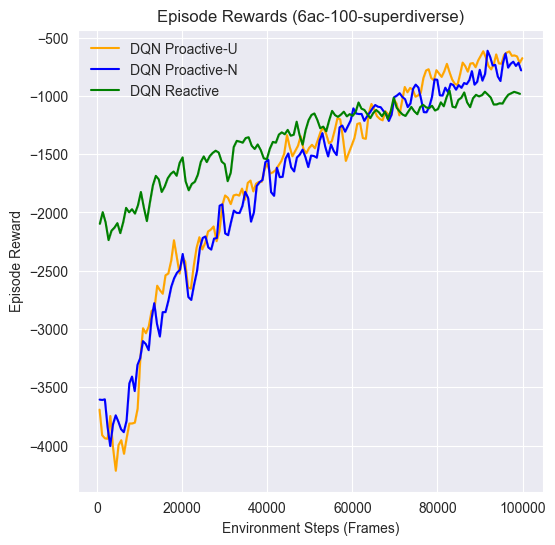

all seeds: {111}

Processing folder: ../2-archive-runs/7-run
Combined plot saved for scenario 6ac-100-superdiverse at ../2-archive-runs/7-run/6ac-100-superdiverse/plots/averaged_rewards_over_steps_6ac-100-superdiverse.png


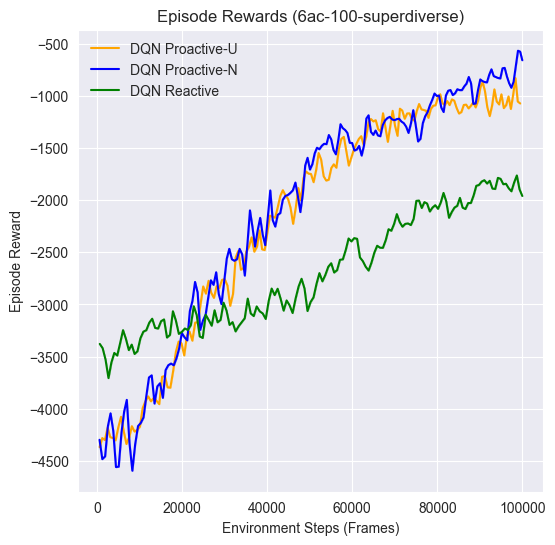

all seeds: {111}

Processing folder: ../2-archive-runs/3-run
Combined plot saved for scenario 6ac-100-superdiverse at ../2-archive-runs/3-run/6ac-100-superdiverse/plots/averaged_rewards_over_steps_6ac-100-superdiverse.png


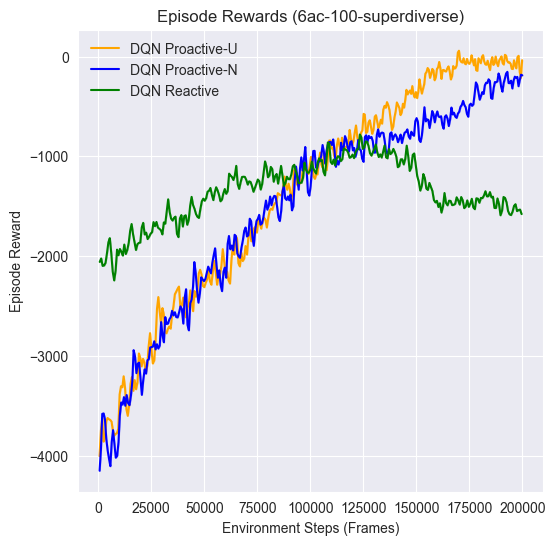

all seeds: {1}

Processing folder: ../2-archive-runs/2-run
Combined plot saved for scenario 6ac-100-superdiverse at ../2-archive-runs/2-run/6ac-100-superdiverse/plots/averaged_rewards_over_steps_6ac-100-superdiverse.png


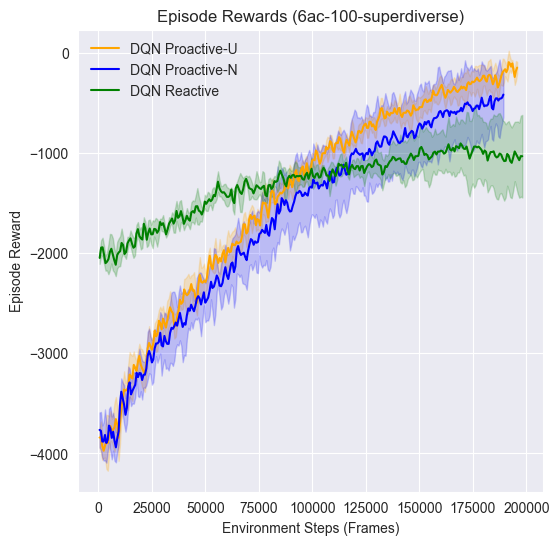

all seeds: {1, 2, 3}

Processing folder: ../2-archive-runs/1-aaa-20m-run
Combined plot saved for scenario 6ac-1300-new-trainer at ../2-archive-runs/1-aaa-20m-run/6ac-1300-new-trainer/plots/averaged_rewards_over_steps_6ac-1300-new-trainer.png


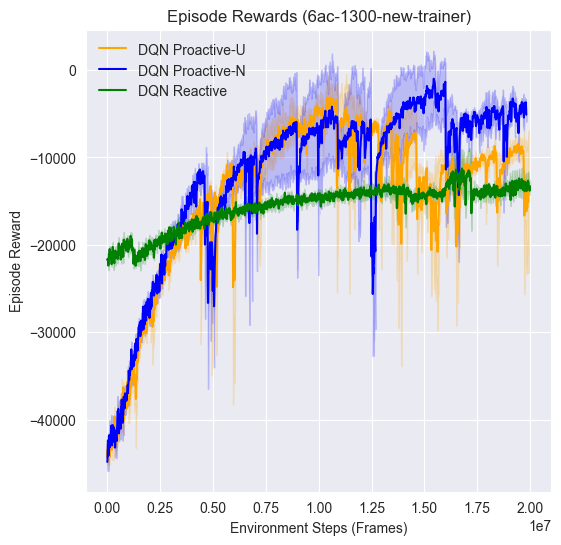

all seeds: {242424, 232323}
No .npy files found in ../2-archive-runs/1-aaa-20m-run/6ac-1000-superdiverse/numpy

Processing folder: ../2-archive-runs/1-run
Combined plot saved for scenario 6ac-100-superdiverse at ../2-archive-runs/1-run/6ac-100-superdiverse/plots/averaged_rewards_over_steps_6ac-100-superdiverse.png


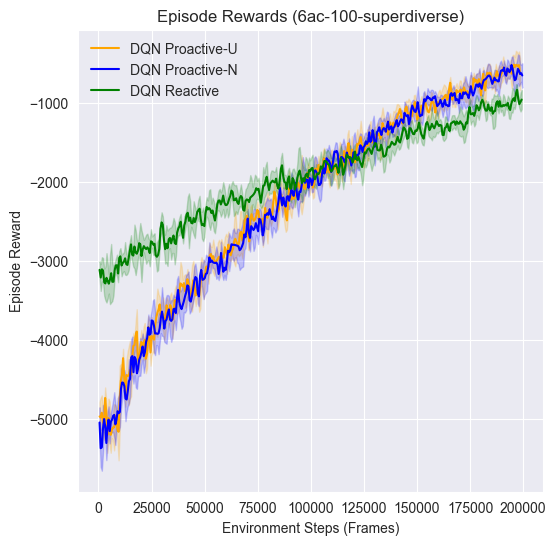

all seeds: {1, 2, 3}

Processing folder: ../2-archive-runs/35-run
No .npy files found in ../2-archive-runs/35-run/6ac-1000-superdiverse/numpy

Processing folder: ../2-archive-runs/26-run
No .npy files found in ../2-archive-runs/26-run/6ac-1000-superdiverse/numpy

Processing folder: ../2-archive-runs/27-run
No .npy files found in ../2-archive-runs/27-run/6ac-1-superdiverse/numpy

Processing folder: ../2-archive-runs/23-run-high-inaction-penalty
No .npy files found in ../2-archive-runs/23-run-high-inaction-penalty/6ac-10000-deterministic/numpy

Processing folder: ../2-archive-runs/19-run
Skipping 6ac-1000-deterministic - no numpy folder found

Processing folder: ../2-archive-runs/18-run
Skipping 6ac-100-superdiverse - no numpy folder found
Skipping 6ac-1-deterministic - no numpy folder found

Processing folder: ../2-archive-runs/30-run
No .npy files found in ../2-archive-runs/30-run/6ac-10000-deterministic/numpy


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import seaborn as sns
sns.set_style("darkgrid")

###################################
# User parameters
###################################
master_folders = ["../2-archive-runs"]  # List of master folders to process
shown_seeds = []  # Only show these seeds, empty list means show all seeds
SMOOTHEDING_WINDOW = 2
###################################

def smooth(data, window=4):
    """Apply a simple moving average smoothing."""
    if isinstance(data, (float, np.float64)):
        return data
    if window > 1 and len(data) >= window:
        return np.convolve(data, np.ones(window)/window, mode='valid')
    return data

# Loop through each master folder
for master_folder in master_folders:
    if not os.path.exists(master_folder):
        print(f"Skipping - The master folder '{master_folder}' does not exist.")
        continue

    print(f"\nProcessing master folder: {master_folder}")
    
    # Get all save folders from current master folder
    save_folders = [
        os.path.join(master_folder, f) 
        for f in os.listdir(master_folder)
        if os.path.isdir(os.path.join(master_folder, f))
    ]

    for save_folder in save_folders:
        print(f"\nProcessing folder: {save_folder}")
        
        # Identify all scenario folders inside the save_folder
        if not os.path.exists(save_folder):
            print(f"Skipping - folder '{save_folder}' does not exist.")
            continue

        scenario_folders = [
            f for f in os.listdir(save_folder) 
            if os.path.isdir(os.path.join(save_folder, f)) and f != 'numpy' and f != 'config.csv'
        ]

        cv = False

        for scenario in scenario_folders:
            scenario_path = os.path.join(save_folder, scenario)
            numpy_path = os.path.join(scenario_path, "numpy")

            if not os.path.exists(numpy_path):
                print(f"Skipping {scenario} - no numpy folder found")
                continue

            # Find all numpy files in the directory
            numpy_files = [f for f in os.listdir(numpy_path) if f.endswith('.npy')]
            
            if not numpy_files:
                print(f"No .npy files found in {numpy_path}")
                continue

            # Create plots directory
            plots_dir = f"{scenario_path}/plots"
            os.makedirs(plots_dir, exist_ok=True)
                
            # Create figure
            plt.figure(figsize=(6,6))
                
            # Group files by agent type
            agent_data = {}
            test_data = {}
            colors = {'proactive': 'orange', 'myopic': 'blue', 'reactive': 'green', 'drl-greedy': 'red'}
            labels = {
                'proactive': 'DQN Proactive-U',
                'myopic': 'DQN Proactive-N', 
                'reactive': 'DQN Reactive'
            }
            
            # Process training data
            for file in numpy_files:
                if 'test_rewards' in file:
                    continue
                    
                if 'runs_seed_' in file and not 'steps' in file:
                    agent_type = file.split('_runs_seed_')[0]
                    data_type = 'runs'
                elif 'steps_runs_seed_' in file:
                    agent_type = file.split('_steps_runs_seed_')[0]
                    data_type = 'steps'
                else:
                    continue
                    
                if agent_type not in agent_data:
                    agent_data[agent_type] = {'runs': [], 'steps': [], 'seeds': set()}
                    
                data = np.load(os.path.join(numpy_path, file))
                seed = int(file.split('_seed_')[1].split('.')[0])
                
                # Skip if seed not in shown_seeds (if shown_seeds is not empty)
                if shown_seeds and seed not in shown_seeds:
                    continue
                    
                if data_type == 'runs':
                    agent_data[agent_type]['runs'].append(data)
                else:
                    agent_data[agent_type]['steps'].append(data)
                agent_data[agent_type]['seeds'].add(seed)

            # Plot training data in specified order
            plot_order = ['proactive', 'myopic', 'reactive']
            for agent_type in plot_order:
                if agent_type not in agent_data:
                    continue
                    
                data = agent_data[agent_type]
                if len(data['runs']) == 0 or len(data['steps']) == 0:
                    print(f"Skipping {agent_type} - missing runs or steps data")
                    continue
                    
                # Find minimum length and truncate arrays
                min_length = min(len(run) for run in data['runs'])
                runs_array = np.array([run[:min_length] for run in data['runs']])
                steps_array = np.array([steps[:min_length] for steps in data['steps']])

                # Calculate statistics
                mean = runs_array.mean(axis=0)
                std = runs_array.std(axis=0)
                steps_mean = steps_array.mean(axis=0).astype(int)

                # Apply smoothing
                smooth_window = SMOOTHEDING_WINDOW
                mean_sm = smooth(mean, smooth_window)
                std_sm = smooth(std, smooth_window)
                steps_sm = steps_mean[:len(mean_sm)]

                plt.plot(steps_sm, mean_sm, label=labels.get(agent_type, agent_type.capitalize()), color=colors.get(agent_type, 'gray'))
                plt.fill_between(steps_sm,
                                mean_sm - std_sm,
                                mean_sm + std_sm,
                                alpha=0.2, color=colors.get(agent_type, 'gray'))

            plt.xlabel("Environment Steps (Frames)")
            plt.ylabel("Episode Reward")
            plt.title(f"Episode Rewards ({scenario})")
            plt.legend(frameon=False)
            plt.grid(True)

            plot_file = os.path.join(plots_dir, f"averaged_rewards_over_steps_{scenario}.png")
            plt.savefig(plot_file)
            print(f"Combined plot saved for scenario {scenario} at {plot_file}")
            plt.show()
            print(f"all seeds: {data['seeds']}")